Using device: cuda
Total valid samples: 118651
Total unique words: 12944

Split: Train=81432, Val=12876, Test=24343
Vocabulary size: 12944 classes

Batch size: 32
Train batches: 2545
Val batches: 403

CREATING MODEL: ResNet101


Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:00<00:00, 183MB/s] 



Model Parameters: 69,022,416

⚙️  Configuration:
   • Training only FC layer initially
   • Optimizer: Adam (lr=0.001)
   • Loss: CrossEntropy (no smoothing)
   • Scheduler: ReduceLROnPlateau

🚀 STARTING TRAINING

Epoch 1/50
----------------------------------------------------------------------
  [100/2545] Loss: 10.9016, Acc: 0.0%
  [200/2545] Loss: 11.5573, Acc: 0.0%
  [300/2545] Loss: 11.7833, Acc: 0.0%
  [400/2545] Loss: 11.2805, Acc: 0.0%
  [500/2545] Loss: 11.1993, Acc: 0.0%
  [600/2545] Loss: 11.6866, Acc: 0.0%
  [700/2545] Loss: 12.9740, Acc: 0.0%
  [800/2545] Loss: 12.1204, Acc: 0.0%
  [900/2545] Loss: 12.6171, Acc: 0.0%
  [1000/2545] Loss: 11.3691, Acc: 3.1%
  [1100/2545] Loss: 12.7527, Acc: 0.0%
  [1200/2545] Loss: 12.1327, Acc: 0.0%
  [1300/2545] Loss: 13.7380, Acc: 0.0%
  [1400/2545] Loss: 12.0629, Acc: 0.0%
  [1500/2545] Loss: 12.0566, Acc: 0.0%
  [1600/2545] Loss: 12.6529, Acc: 0.0%
  [1700/2545] Loss: 13.0992, Acc: 0.0%
  [1800/2545] Loss: 11.7100, Acc: 3.1%
  [1900/25

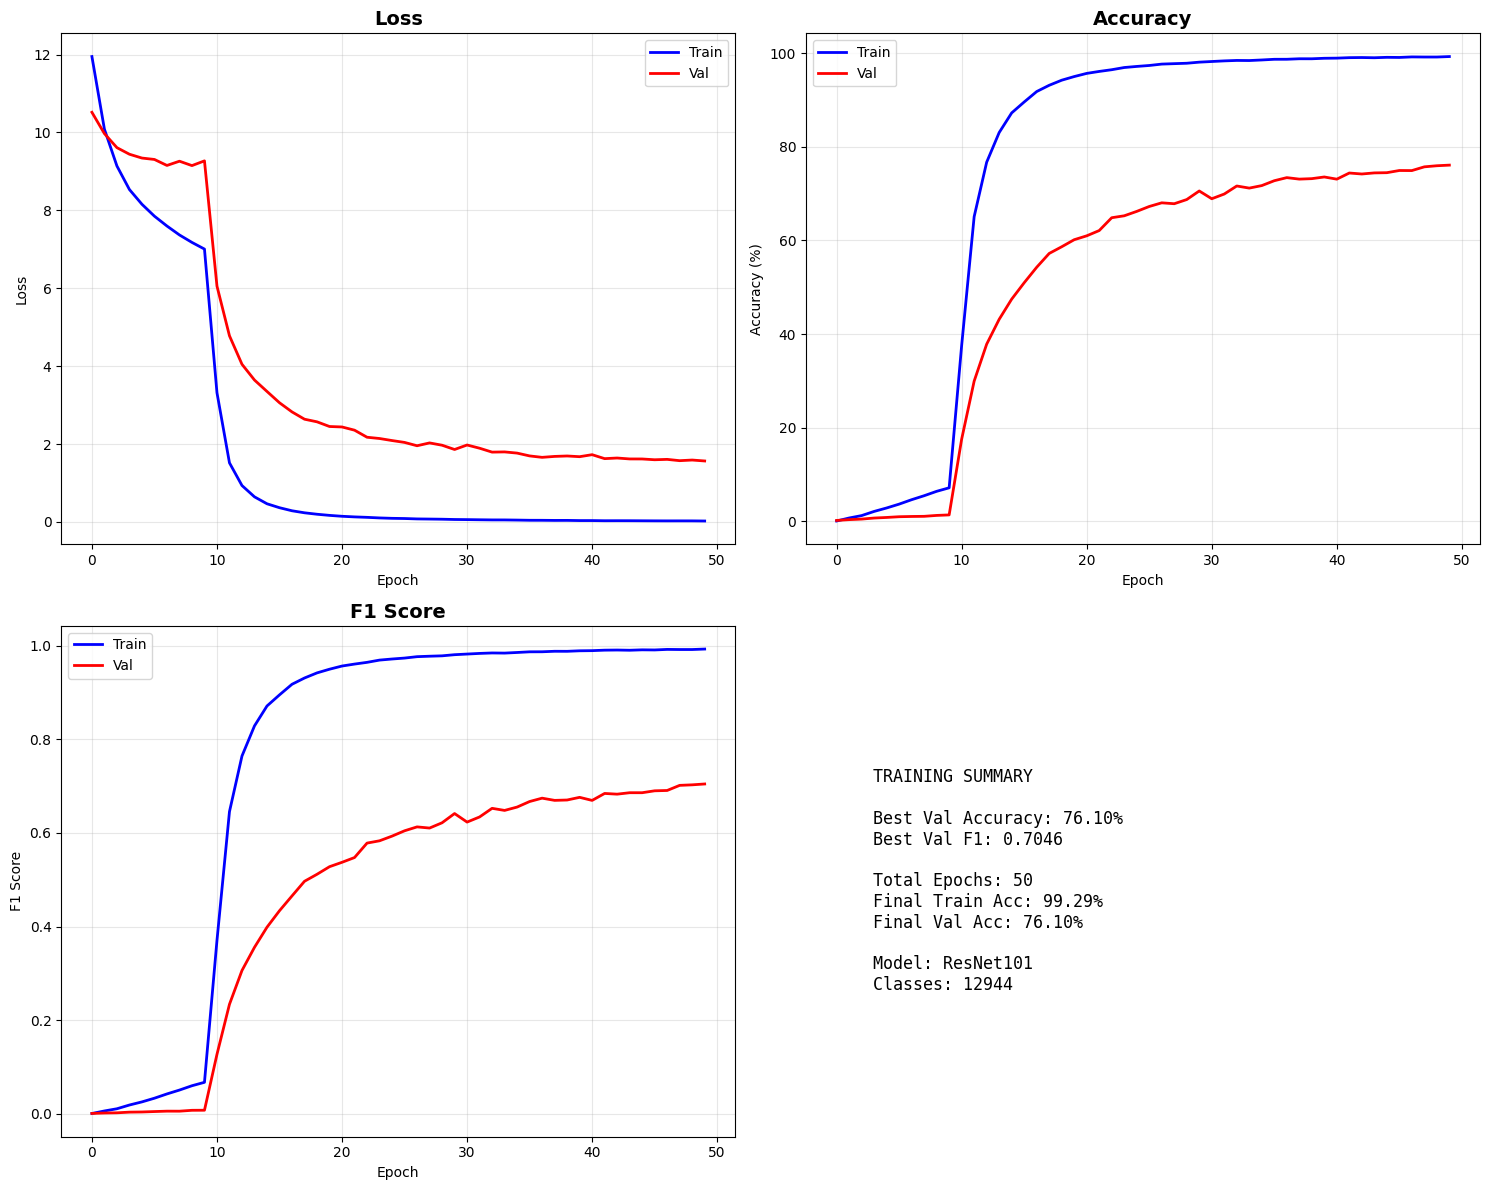


📊 EVALUATION

🎯 TEST RESULTS:
   Accuracy:  79.54%
   Precision: 0.8202
   Recall:    0.7954
   F1-Score:  0.7784


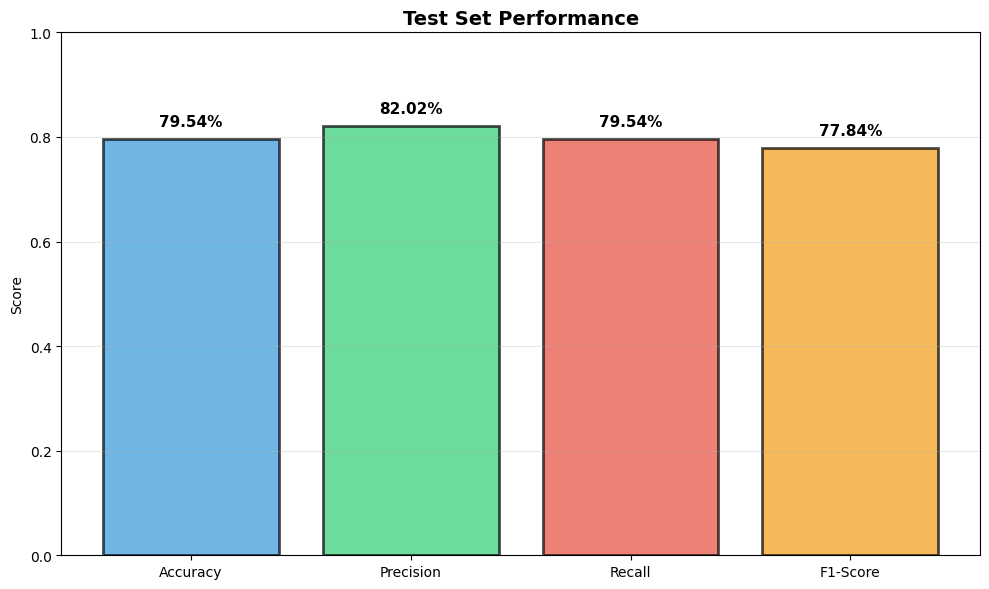


🧪 TESTING PREDICTIONS

🎯 TELUGU HANDWRITING RECOGNITION



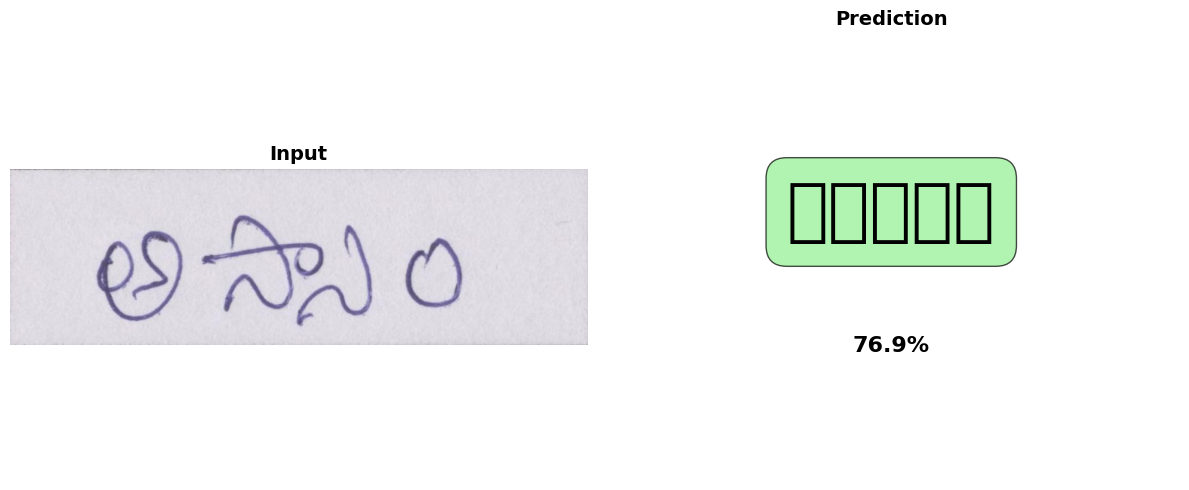

✅ PREDICTED: అన్నా (76.9%)

Top 5:
  1. అన్నా                 76.9%
  2. అన్నమ్మ                8.0%
  3. తిప్పాలి               6.2%
  4. అస్సాం                 4.1%
  5. స్కాం                  1.5%

🔊 Generating speech...



Actual: అస్సాం
Match: ❌


🎯 TELUGU HANDWRITING RECOGNITION



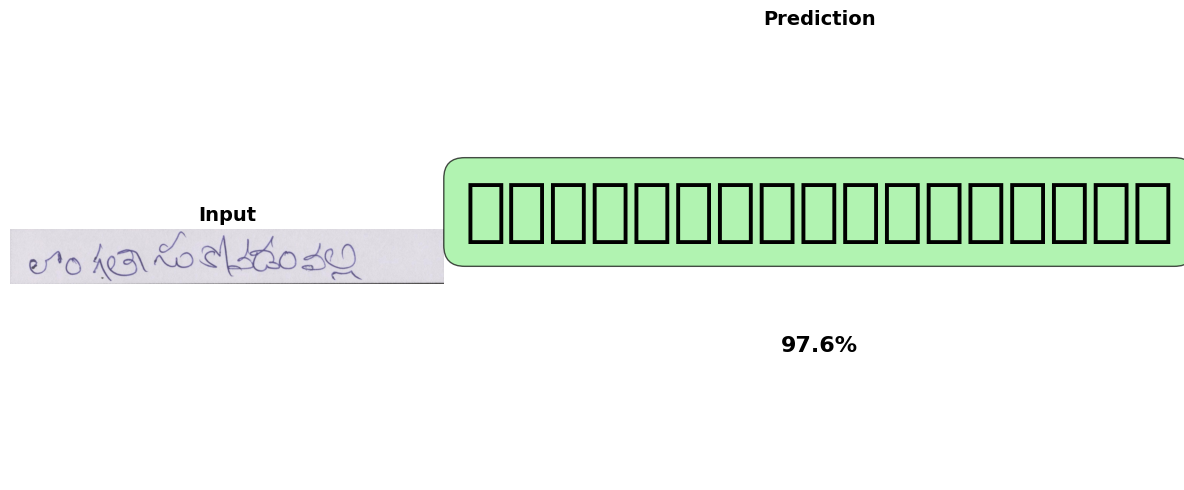

✅ PREDICTED: లొంగతీసుకోవడంవల్ల (97.6%)

Top 5:
  1. లొంగతీసుకోవడంవల్ల     97.6%
  2. లంకించుకున్నందువల్ల    2.2%
  3. అభిప్రాయపడినట్లు       0.1%
  4. భుజాలకెత్తుకున్నాం     0.0%
  5. అనే్వషించలేకపోతున్నారు   0.0%

🔊 Generating speech...



Actual: లొంగతీసుకోవడంవల్ల
Match: ✅


🎯 TELUGU HANDWRITING RECOGNITION



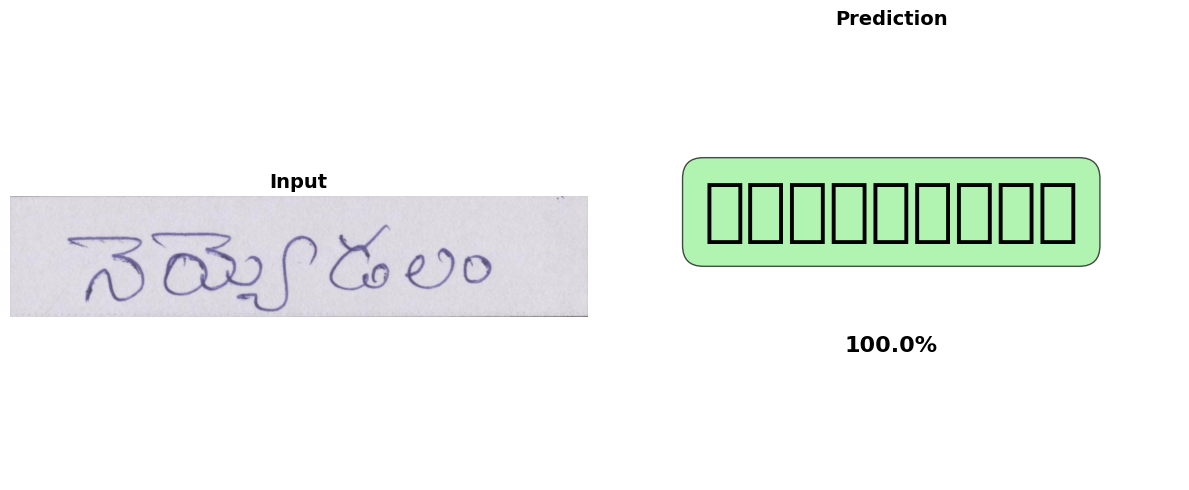

✅ PREDICTED: నెయ్యెడలం (100.0%)

Top 5:
  1. నెయ్యెడలం            100.0%
  2. నాకవ్వంబు              0.0%
  3. ఇరవైరెండు              0.0%
  4. మరెవరూ                 0.0%
  5. చెప్పగలరు              0.0%

🔊 Generating speech...



Actual: నెయ్యెడలం
Match: ✅


✅ COMPLETE!
Best Val Acc: 76.10%
Test Acc: 79.54%


In [2]:
"""
FIXED TELUGU HANDWRITING RECOGNITION
=====================================
Properly configured model that will actually learn
"""

!pip install gtts --quiet

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from gtts import gTTS
from IPython.display import Audio, display
import copy
import random
import numpy as np
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score
import json
import matplotlib.pyplot as plt

# ============================================
# SETUP
# ============================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

DATASET_DIR = "/kaggle/input/sreeteluguhand"
PROJECT_ROOT = "/kaggle/working"
MODELS_DIR = os.path.join(PROJECT_ROOT, "models")
RESULTS_DIR = os.path.join(PROJECT_ROOT, "results")

for directory in [PROJECT_ROOT, MODELS_DIR, RESULTS_DIR]:
    os.makedirs(directory, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================================
# DATA LOADING
# ============================================
def create_corrected_split_files(dataset_dir):
    file_paths = ["train.txt", "val.txt", "test.txt"]
    all_valid_data = []

    for file_path in file_paths:
        full_file_path = os.path.join(dataset_dir, file_path)
        if not os.path.exists(full_file_path):
            continue

        with open(full_file_path, "r", encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split(maxsplit=1)
                if len(parts) != 2:
                    continue

                image_path_rel = parts[0]
                word = parts[1]
                full_image_path = os.path.join(dataset_dir, "TeluguSeg", image_path_rel)

                if os.path.exists(full_image_path):
                    all_valid_data.append({
                        'image_path': full_image_path,
                        'word': word.strip(),
                        'relative_path': image_path_rel
                    })

    print(f"Total valid samples: {len(all_valid_data)}")
    return all_valid_data

all_data = create_corrected_split_files(DATASET_DIR)

word_groups = defaultdict(list)
for item in all_data:
    word_groups[item['word']].append(item)

print(f"Total unique words: {len(word_groups)}")

train_raw, val_raw, test_raw = [], [], []

for word, items in word_groups.items():
    random.shuffle(items)
    if len(items) >= 3:
        n_train = max(1, int(len(items) * 0.7))
        n_val = max(1, int(len(items) * 0.15))
        train_raw.extend(items[:n_train])
        val_raw.extend(items[n_train:n_train + n_val])
        test_raw.extend(items[n_train + n_val:])
    elif len(items) == 2:
        train_raw.append(items[0])
        val_raw.append(items[1])
    elif len(items) == 1:
        train_raw.append(items[0])

print(f"\nSplit: Train={len(train_raw)}, Val={len(val_raw)}, Test={len(test_raw)}")

all_words = sorted(list(set(item['word'] for item in train_raw + val_raw + test_raw)))
word_to_id = {word: i for i, word in enumerate(all_words)}
id_to_word = {i: word for word, i in word_to_id.items()}

for item in train_raw:
    item['vocab_id'] = word_to_id[item['word']]
for item in val_raw:
    item['vocab_id'] = word_to_id[item['word']]
for item in test_raw:
    item['vocab_id'] = word_to_id[item['word']]

print(f"Vocabulary size: {len(all_words)} classes")

vocab_path = os.path.join(MODELS_DIR, 'vocabulary.json')
with open(vocab_path, 'w', encoding='utf-8') as f:
    json.dump(id_to_word, f, ensure_ascii=False, indent=2)

# ============================================
# DATASET
# ============================================
class TeluguHandwritingDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]['image_path']
        image = Image.open(img_path).convert('RGB')
        label = self.data[idx]['vocab_id']

        if self.transform:
            image = self.transform(image)

        return image, label

# Proper augmentation - not too aggressive
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = TeluguHandwritingDataset(train_raw, transform=train_transforms)
val_dataset = TeluguHandwritingDataset(val_raw, transform=val_test_transforms)
test_dataset = TeluguHandwritingDataset(test_raw, transform=val_test_transforms)

# Smaller batch size for stability
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print(f"\nBatch size: 32")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# ============================================
# MODEL - RESNET101 (PROVEN TO WORK)
# ============================================
print("\n" + "="*70)
print("CREATING MODEL: ResNet101")
print("="*70)

model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

# Replace final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(all_words))
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"\nModel Parameters: {total_params:,}")

# Simple CrossEntropy - NO label smoothing initially
criterion = nn.CrossEntropyLoss()

# Start with ONLY training the final layer
for name, param in model.named_parameters():
    if 'fc' not in name:
        param.requires_grad = False

# Higher learning rate for new layer
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

print(f"\n⚙️  Configuration:")
print(f"   • Training only FC layer initially")
print(f"   • Optimizer: Adam (lr=0.001)")
print(f"   • Loss: CrossEntropy (no smoothing)")
print(f"   • Scheduler: ReduceLROnPlateau")

# ============================================
# TRAINING
# ============================================
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs=50):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    patience = 10
    epochs_no_improve = 0
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'train_f1': [], 'val_f1': []
    }
    
    for epoch in range(num_epochs):
        print(f'\n{"="*70}')
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print("-"*70)

        # TRAINING
        model.train()
        running_loss = 0.0
        running_corrects = 0
        all_train_preds = []
        all_train_labels = []
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())
            
            if (batch_idx + 1) % 100 == 0:
                batch_acc = torch.sum(preds == labels.data).item() / inputs.size(0)
                print(f'  [{batch_idx + 1}/{len(train_loader)}] Loss: {loss.item():.4f}, Acc: {batch_acc*100:.1f}%')

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.double() / len(train_loader.dataset)
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)

        # VALIDATION
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        all_val_preds = []
        all_val_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted', zero_division=0)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc.item())
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())
        history['val_f1'].append(val_f1)

        print(f'\n📊 RESULTS:')
        print(f'   Train: Loss={train_loss:.4f}, Acc={train_acc*100:.2f}%, F1={train_f1:.4f}')
        print(f'   Val:   Loss={val_loss:.4f}, Acc={val_acc*100:.2f}%, F1={val_f1:.4f}')

        scheduler.step(val_acc)
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            print(f'   ✅ NEW BEST: {best_acc*100:.2f}%')
        else:
            epochs_no_improve += 1
            
        # Unfreeze more layers after epoch 10
        if epoch == 9:
            print("\n🔓 Unfreezing layer4...")
            for name, param in model.named_parameters():
                if 'layer4' in name or 'fc' in name:
                    param.requires_grad = True
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
            scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
            
        if epochs_no_improve >= patience:
            print(f'\n⚠️  Early stopping')
            break

    print(f'\n🏆 BEST VAL ACC: {best_acc*100:.2f}%')
    model.load_state_dict(best_model_wts)
    return model, history

# ============================================
# TRAIN
# ============================================
print("\n" + "="*70)
print("🚀 STARTING TRAINING")
print("="*70)

best_model, history = train_model(
    model, criterion, optimizer, scheduler, 
    train_loader, val_loader, device, num_epochs=50
)

model_path = os.path.join(MODELS_DIR, "resnet101_telugu_working.pth")
torch.save(best_model.state_dict(), model_path)
print(f"\n✅ Model saved: {model_path}")

history_path = os.path.join(RESULTS_DIR, "training_history.json")
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)

# ============================================
# PLOTS
# ============================================
print("\n📈 Generating plots...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Loss
axes[0, 0].plot(history['train_loss'], 'b-', label='Train', linewidth=2)
axes[0, 0].plot(history['val_loss'], 'r-', label='Val', linewidth=2)
axes[0, 0].set_title('Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot([x*100 for x in history['train_acc']], 'b-', label='Train', linewidth=2)
axes[0, 1].plot([x*100 for x in history['val_acc']], 'r-', label='Val', linewidth=2)
axes[0, 1].set_title('Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# F1 Score
axes[1, 0].plot(history['train_f1'], 'b-', label='Train', linewidth=2)
axes[1, 0].plot(history['val_f1'], 'r-', label='Val', linewidth=2)
axes[1, 0].set_title('F1 Score', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Summary
axes[1, 1].axis('off')
summary_text = f"""
TRAINING SUMMARY

Best Val Accuracy: {max(history['val_acc'])*100:.2f}%
Best Val F1: {max(history['val_f1']):.4f}

Total Epochs: {len(history['train_acc'])}
Final Train Acc: {history['train_acc'][-1]*100:.2f}%
Final Val Acc: {history['val_acc'][-1]*100:.2f}%

Model: ResNet101
Classes: {len(all_words)}
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=12, family='monospace',
                verticalalignment='center')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'training_curves.png'), dpi=300)
plt.show()

# ============================================
# EVALUATION
# ============================================
print("\n" + "="*70)
print("📊 EVALUATION")
print("="*70)

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = (all_preds == all_labels).sum() / len(all_labels)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"\n🎯 TEST RESULTS:")
print(f"   Accuracy:  {accuracy*100:.2f}%")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")

# Metrics plot
fig, ax = plt.subplots(figsize=(10, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

bars = ax.bar(metrics, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Score')
ax.set_title('Test Set Performance', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.0])
ax.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{value*100:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'test_metrics.png'), dpi=300)
plt.show()

test_results = {'accuracy': float(accuracy), 'precision': float(precision),
                'recall': float(recall), 'f1_score': float(f1)}
with open(os.path.join(RESULTS_DIR, "test_results.json"), 'w') as f:
    json.dump(test_results, f, indent=2)

# ============================================
# PREDICTION
# ============================================
def predict_and_speak(image_path, show_top_k=5):
    try:
        print(f"\n{'='*70}")
        print("🎯 TELUGU HANDWRITING RECOGNITION")
        print(f"{'='*70}\n")
        
        image = Image.open(image_path).convert('RGB')
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        axes[0].imshow(image)
        axes[0].set_title('Input', fontsize=14, fontweight='bold')
        axes[0].axis('off')
        
        input_tensor = val_test_transforms(image)
        input_batch = input_tensor.unsqueeze(0).to(device)
        
        model.eval()
        with torch.no_grad():
            output = model(input_batch)
            probs = torch.nn.functional.softmax(output, dim=1)
            top_probs, top_indices = torch.topk(probs, show_top_k)
            
            predicted_id = top_indices[0][0].item()
            confidence = top_probs[0][0].item()
        
        telugu_word = id_to_word.get(predicted_id, "Unknown")
        
        axes[1].text(0.5, 0.6, telugu_word, fontsize=50, ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
        axes[1].text(0.5, 0.3, f'{confidence*100:.1f}%', fontsize=16, ha='center', 
                    va='center', fontweight='bold')
        axes[1].set_title('Prediction', fontsize=14, fontweight='bold')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, 'prediction.png'), dpi=300)
        plt.show()
        
        print(f"✅ PREDICTED: {telugu_word} ({confidence*100:.1f}%)\n")
        
        print("Top 5:")
        for i in range(show_top_k):
            word_id = top_indices[0][i].item()
            prob = top_probs[0][i].item()
            word = id_to_word.get(word_id, "Unknown")
            print(f"  {i+1}. {word:20s} {prob*100:5.1f}%")
        
        print(f"\n🔊 Generating speech...")
        audio_path = os.path.join(RESULTS_DIR, 'output.mp3')
        tts = gTTS(text=telugu_word, lang='te', slow=False)
        tts.save(audio_path)
        display(Audio(audio_path, autoplay=True))
        
        return telugu_word, confidence
        
    except Exception as e:
        print(f"❌ Error: {e}")
        return None, None

# Test
if len(test_raw) > 0:
    print("\n" + "="*70)
    print("🧪 TESTING PREDICTIONS")
    print("="*70)
    
    for i in range(min(3, len(test_raw))):
        sample = random.choice(test_raw)
        pred, conf = predict_and_speak(sample['image_path'])
        print(f"\nActual: {sample['word']}")
        print(f"Match: {'✅' if pred == sample['word'] else '❌'}\n")\

print("\n" + "="*70)
print("✅ COMPLETE!")
print("="*70)
print(f"Best Val Acc: {max(history['val_acc'])*100:.2f}%")
print(f"Test Acc: {accuracy*100:.2f}%")
print("="*70)